In [1]:
!pip install simpy
!pip install numpy
!pip install matplotlib

In [2]:
import random
import simpy
import numpy
import matplotlib.pyplot as plt
import math

In [3]:
class BaseDeDatos(simpy.Resource):

  def __init__(self, env, mu_demora, probabilidad = 1):
    super().__init__(env, 1)

    self.mu_demora = mu_demora
    self.probabilidad = probabilidad # Probabilidad de atender solicitud

  def get_demora_solicitud(self):
    return random.expovariate(1 / self.mu_demora)

In [4]:
class Solicitud():

  def __init__(self, env):
    self.env = env

  def procesar(self, bdd, estadisticas):
    tiempo_llegada = self.env.now

    with bdd.request() as req:
      yield req

      tiempo_inicio_proceso = self.env.now
      tiempo_de_espera = tiempo_inicio_proceso - tiempo_llegada
      estadisticas.agregar_tiempo_de_espera(tiempo_de_espera)

      demora = bdd.get_demora_solicitud()
      yield self.env.timeout(demora)

In [5]:
class Estadisticas():

    def __init__(self):
      self.espera_acumulada = 0
      self.solicitudes_atendidas_sin_espera = 0
      self.numero_solicitud = 0
      self.historial_tiempos_espera = []
      self.historial_solicitudes = []

    def agregar_tiempo_de_espera(self, tiempo_de_espera):
      self.numero_solicitud += 1
      if tiempo_de_espera == 0:
        self.solicitudes_atendidas_sin_espera += 1

      self.espera_acumulada += tiempo_de_espera
      self.historial_tiempos_espera.append(tiempo_de_espera)
      self.historial_solicitudes.append(self.numero_solicitud)

    def tiempo_medio_de_espera(self):
      return self.espera_acumulada / cantidad_solicitudes

    def proporcion_solicitudes_sin_espera(self):
      return self.solicitudes_atendidas_sin_espera / cantidad_solicitudes

    def histograma_tiempos_espera(self, titulo, num_intervalos=100):
        media_espera = self.tiempo_medio_de_espera()
        plt.figure().set_figwidth(10)
        barra_color = '#4A90E2'
        linea_color = 'yellow'
        plt.hist(self.historial_tiempos_espera, bins=num_intervalos, edgecolor='black', color=barra_color, log=True)
        plt.axvline(media_espera, color=linea_color, linestyle='dashed', linewidth=1, label=f'Media: {media_espera:.3f}')
        plt.legend()
        plt.title(titulo)
        plt.xlabel("Tiempo de espera")
        plt.ylabel("Cantidad de solicitudes (log)")
        plt.show()

    def grafico_tiempo_espera_vs_solicitudes(self, titulo):
        plt.figure().set_figwidth(10)
        plt.plot(self.historial_solicitudes, self.historial_tiempos_espera, color='#4A90E2')
        plt.xscale('log')
        plt.title(titulo)
        plt.xlabel("Número de solicitud (log)")
        plt.ylabel("Tiempo de espera")
        plt.show()

    def grafico_proporcion_solicitudes_sin_esperar(self, titulo):
        proporcion = self.proporcion_solicitudes_sin_espera()
        sizes = [1 - proporcion, proporcion]
        labels = ['Solicitudes con espera', 'Solicitudes sin espera']
    
        colores = ['#A2B9C9', '#4A90E2']
        plt.figure().set_figwidth(10)
        wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colores,
                                           wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
        plt.title(titulo)
        plt.axis('equal')
        plt.show()

In [6]:
def generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas):
    for _ in range(cantidad_solicitudes):
        bdd = seleccionar_base_de_datos(bases_de_datos)

        solicitud = Solicitud(env)
        env.process(solicitud.procesar(bdd, estadisticas))

        t = random.expovariate(1.0 / intervalo_llegadas)
        yield env.timeout(t)

def seleccionar_base_de_datos(bases_de_datos):
  return numpy.random.choice(bases_de_datos, p = [bdd.probabilidad for bdd in bases_de_datos])

In [7]:
def simular_una_base(mu_demora):
  env = simpy.Environment()

  estadisticas = Estadisticas()    
  bases_de_datos = [BaseDeDatos(env, mu_demora)]
  env.process(generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas))
  env.run()
  return estadisticas

In [8]:
def simular_dos_bases(mu_demora_1, mu_demora_2):
  env = simpy.Environment()

  estadisticas = Estadisticas()    
  bases_de_datos = [BaseDeDatos(env, mu_demora_1, 0.7), BaseDeDatos(env, mu_demora_2, 0.3)]
  env.process(generar_solicitudes(env, cantidad_solicitudes, intervalo_llegadas, bases_de_datos, estadisticas))
  env.run()
  return estadisticas

In [9]:
cantidad_solicitudes = 100_000
intervalo_llegadas = 4

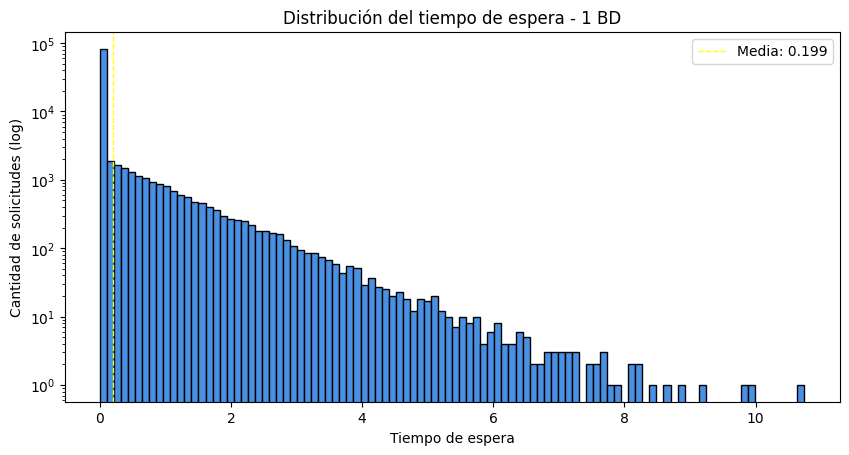

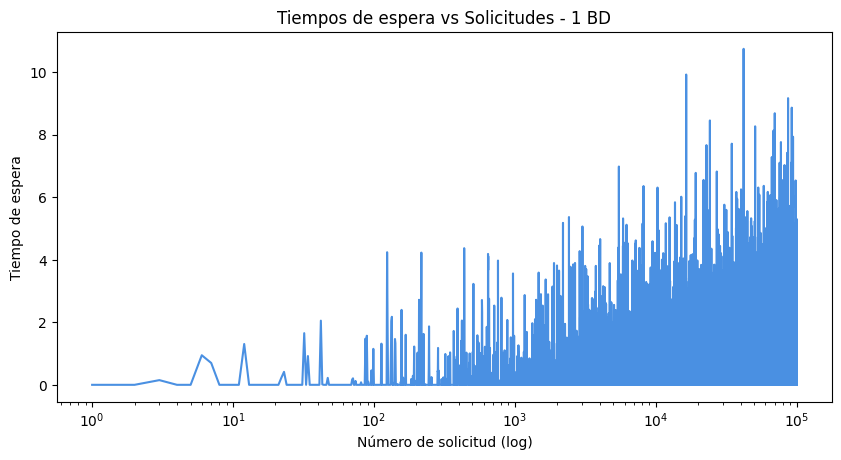

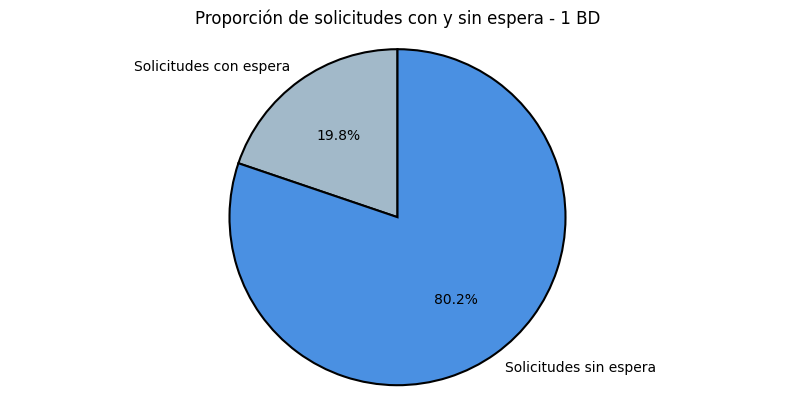

In [10]:
# Simulacion de una sola base
mu_demora = 0.8
estadisticas = simular_una_base(mu_demora)
estadisticas.histograma_tiempos_espera("Distribución del tiempo de espera - 1 BD")
estadisticas.grafico_tiempo_espera_vs_solicitudes("Tiempos de espera vs Solicitudes - 1 BD")
estadisticas.grafico_proporcion_solicitudes_sin_esperar("Proporción de solicitudes con y sin espera - 1 BD")

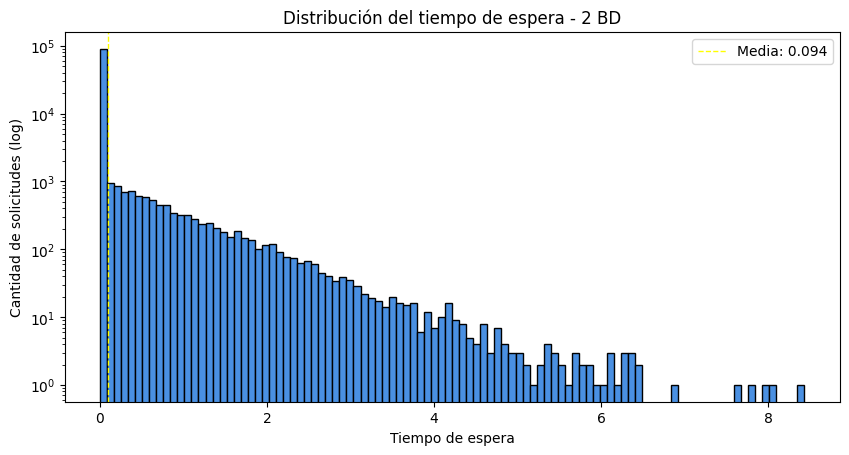

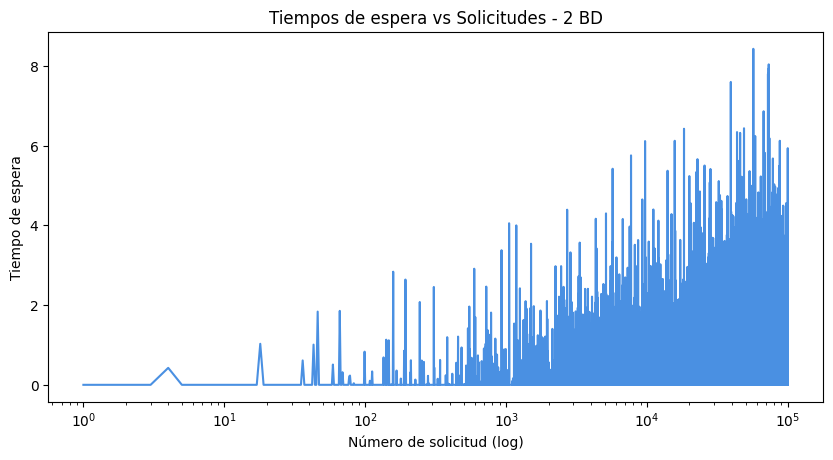

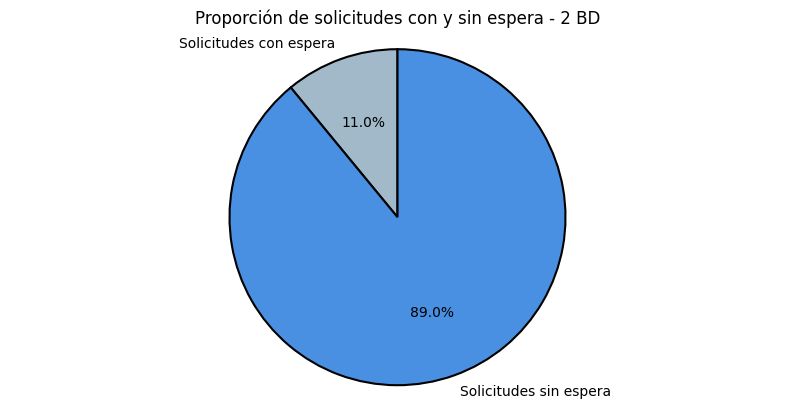

In [11]:
# Simulacion de dos bases
mu_demora_1 = 0.7
mu_demora_2 = 1
estadisticas = simular_dos_bases(mu_demora_1, mu_demora_2)
estadisticas.histograma_tiempos_espera("Distribución del tiempo de espera - 2 BD")
estadisticas.grafico_tiempo_espera_vs_solicitudes("Tiempos de espera vs Solicitudes - 2 BD")
estadisticas.grafico_proporcion_solicitudes_sin_esperar("Proporción de solicitudes con y sin espera - 2 BD")